In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback

In [4]:
#ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

#load dataframe
df = pd.read_csv("mlware23/dataset/train/train_landmarks.csv", dtype = dt)

In [5]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("mlware23/dataset/train/landmarks/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'ground_truth')

<Figure size 432x288 with 0 Axes>

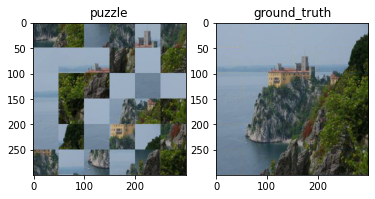

In [6]:
puzzle, solved = rearrange(df, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(solved)
axarr[1].set_title("ground_truth")

In [7]:
#train test split
n = len(df)
val_split = 0.2
val_df = df[:int(n*val_split)]
train_df = df[int(n*val_split):]

In [8]:
def load_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("mlware23/dataset/train/landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [9]:
train_img = load_images(train_df)
val_img = load_images(val_df)

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 153.93it/s]


In [10]:
print(train_img.shape)
print(val_img.shape)

(2400, 36, 50, 50, 3)
(600, 36, 50, 50, 3)


In [11]:
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

In [12]:
train_labels = load_labels(train_df)
val_labels = load_labels(val_df)

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1958.84it/s]


In [13]:
print(train_labels.shape)
print(val_labels.shape)

(2400, 36, 36)
(600, 36, 36)


In [14]:
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once

#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch1 = tf.keras.layers.BatchNormalization()
max_pool1 = tf.keras.layers.MaxPooling2D()
conv2 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch2 = tf.keras.layers.BatchNormalization()
max_pool2 = tf.keras.layers.MaxPooling2D()
conv3 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch3 = tf.keras.layers.BatchNormalization()
max_pool3 = tf.keras.layers.MaxPooling2D()
flat = tf.keras.layers.Flatten()
dense1 = tf.keras.layers.Dense(36)

#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i])
    x = batch1(x)
    x = max_pool1(x)
    x = conv2(x)
    x = batch2(x)
    x = max_pool2(x)
    x = conv3(x)
    x = batch3(x)
    x = max_pool3(x)
    x = flat(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

In [15]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [16]:
# tf.keras.utils.plot_model(model)
# an image of our model architecture
# double click to expand

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [17]:
filepath = f'checkpoint/'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_weights_only=False, save_best_only=True)
tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [tensorboard, checkpoint]

# For fast trial of notebook we have set epoch to 2
## Although for our submission on leaderboard we have trained for 10 epochs same as faces 

In [21]:
model.fit(x=train_img, 
          y=train_labels, 
          batch_size=16, 
          validation_data=[val_img, val_labels], 
          shuffle=True,
          epochs=2,          
          callbacks = [callbacks_list])

Epoch 1/2
150/150 [==============================] - ETA: 0s - loss: 3.3991
Epoch 1: val_loss improved from inf to 3.36412, saving model to checkpoint\
INFO:tensorflow:Assets written to: checkpoint\assets
150/150 [==============================] - 630s 4s/step - loss: 3.3991 - val_loss: 3.3641
Epoch 2/2
150/150 [==============================] - ETA: 0s - loss: 3.3606
Epoch 2: val_loss improved from 3.36412 to 3.33749, saving model to checkpoint\
INFO:tensorflow:Assets written to: checkpoint\assets
150/150 [==============================] - 628s 4s/step - loss: 3.3606 - val_loss: 3.3375


In [22]:
# To open tensorboard run this command in your terminal:
# tensorboard --logdir='logs/'

In [23]:
def load_test_image_data(test_data_path):
    
    x_test = []
    
    dir_lst = os.listdir(test_data_path)
    
    for i in dir_lst:
        pieces = []
        img = Image.open(test_data_path+'/'+i)
        img = np.array(img)
#         print(im.size)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        x_test.append(pieces)
    return np.array(x_test)


test_data_path = 'mlware23/dataset/test/landmarks'
print('Number of Images in the face test dataset:',len(os.listdir(test_data_path)))
x_test = load_test_image_data(test_data_path)
print(x_test.shape)

Number of Images in the face test dataset: 1096
(1096, 36, 50, 50, 3)


In [24]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=-1)

In [25]:
pred_list = []
for i in range(pred.shape[0]):
    t = []
    for j in range(pred[i].shape[0]):
        t.append(str(pred[i][j]//6) + str(pred[i][j]%6))
    pred_list.append(t)

# image_df = pd.DataFrame(val_df["image"])
# label_df = pd.DataFrame(pred_list)
test_data_path = 'mlware23/dataset/test/landmarks'
test_data_dir = os.listdir(test_data_path)
image_df = pd.DataFrame(i for i in test_data_dir)
label_df = pd.DataFrame(pred_list)
out = pd.concat([image_df, label_df], axis=1)
out.columns = df.columns

In [26]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

In [27]:
submission = prediction_to_submission(out)

In [28]:
submission.to_csv('MY_LANDMARK_PREDS.csv', index=False)
print('Done!')

Done!


In [29]:
# In the same way we predicted the values for Face image and saved the results in a csv file.

In [31]:
# Preparing the csv files obtained in the submission format so that they can be submitted to Kaggle.

df1 = pd.read_csv('MY_FACE_PREDS.csv')
df2 = pd.read_csv('MY_LANDMARK_PREDS.csv')

df3 = pd.concat([df1,df2], axis=0)
print(df3.shape)
print(df3.columns)
print(df3.head())

df3.to_csv('SUBMIT_IT_4.csv', index=False)

(1996, 73)
Index(['image', 'r00', 'r01', 'r02', 'r03', 'r04', 'r05', 'r10', 'r11', 'r12',
       'r13', 'r14', 'r15', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r30',
       'r31', 'r32', 'r33', 'r34', 'r35', 'r40', 'r41', 'r42', 'r43', 'r44',
       'r45', 'r50', 'r51', 'r52', 'r53', 'r54', 'r55', 'c00', 'c01', 'c02',
       'c03', 'c04', 'c05', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c20',
       'c21', 'c22', 'c23', 'c24', 'c25', 'c30', 'c31', 'c32', 'c33', 'c34',
       'c35', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c50', 'c51', 'c52',
       'c53', 'c54', 'c55'],
      dtype='object')
            image  r00  r01  r02  r03  r04  r05  r10  r11  r12  ...  c42  c43  \
0  00iOHCZTws.jpg    2    3    1    5    0    2    3    1    1  ...    3    5   
1  03fxX7jYxI.jpg    3    0    1    1    3    5    2    2    0  ...    5    4   
2  05evYM76RD.jpg    1    1    4    3    3    1    1    2    4  ...    5    2   
3  08UaxmNJtO.jpg    3    2    2    5    5    5    4    3    4  ...    3 

In [33]:
df3

,image,r00,r01,r02,r03,r04,r05,r10,r11,r12,...,c42,c43,c44,c45,c50,c51,c52,c53,c54,c55
0,00iOHCZTws.jpg,2,3,1,5,0,2,3,1,1,...,3,5,1,5,2,4,2,0,5,4
1,03fxX7jYxI.jpg,3,0,1,1,3,5,2,2,0,...,5,4,1,2,0,3,2,5,4,1
2,05evYM76RD.jpg,1,1,4,3,3,1,1,2,4,...,5,2,5,0,3,3,0,1,0,1
3,08UaxmNJtO.jpg,3,2,2,5,5,5,4,3,4,...,3,2,4,2,5,1,2,4,2,0
4,09gb5hcslV.jpg,4,1,3,5,5,2,5,1,4,...,0,5,4,2,1,2,5,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,ZvPT7U2d8t.jpg,0,0,0,5,4,1,0,2,0,...,4,4,4,2,3,0,4,2,4,1
1092,zWvXAlyr58.jpg,0,0,0,0,0,1,0,0,1,...,0,1,1,1,1,1,3,1,1,4
1093,ZxyuoYKkWo.jpg,4,3,1,0,2,0,4,1,5,...,4,5,0,0,4,4,4,1,4,0
1094,ZyGLUkWzNC.jpg,3,3,0,5,5,0,5,0,4,...,0,2,1,0,3,0,2,2,1,1
